In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import time
import scipy

#Separate import for numpy and jax.numpy to have major felxibility
import jax.numpy as jnp
import numpy as np
from jax import jit,lax,random
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions
from tensorflow_probability.substrates import jax as jtfp
jtfd = jtfp.distributions

np.random.seed(0)

In [157]:
sampled_perturbed = np.load('sampled_2D_two_clusters.npy')
data = sampled_perturbed[0 : 1000]
#DEFINING NUMBER OF CLUSTERS AND DIMENSION OF DATA
k = 8
d = 2
#Key to store for random generation
rng_key = random.PRNGKey(0)
uniq_vals_recorded = []
cluster_allocs_recorded = []

In [187]:
def run_one_gibbs(data, cluster_allocs, uniq_vals, weights, alpha, lam,count,count_tot):
    
    """
    Run one gibbs sampler iteration
    Takes in input values of the previous iteration and sample the new values from sample_uniq_vals_fullcond, update_weights and update_cluster_allocs
    Returns:   
    
    -cluster_allocs: for every data point, the cluster assigned
    -uniq_vals: array of parameters of the distributions. Matrix has d rows of the type:[mu[0], var[0,0], var[0,1]]
    -weights: array with the weights of the clusters 
     """
    
    n_clus = len(weights)
    
    for h in range(n_clus):
        
        #Extract data assigned to cluster h and sample 
        clusdata = data[cluster_allocs == h]
        if len(clusdata) != 0:
            #print(uniq_vals)
            #print(":::::")
            #print(uniq_vals[h, :])
            #uniq_vals[h, :] = sample_uniq_vals_fullcond(clusdata, lam)
            uniq_vals[h, :], acc_rate,count,count_tot = sample_uniq_vals_fullcond_Wasserstein_NW_log(clusdata, lam, uniq_vals, h,count,count_tot)
            #print(uniq_vals)
            #print(":::::")
            #print(uniq_vals[h, :])
        else:
            print("sono qua")
            uniq_vals[h, :] = sample_uniq_vals_prior(lam)

    weights = update_weights(cluster_allocs ,n_clus, k, alpha)
    #print(weights)
    
    cluster_allocs = update_cluster_allocs(data, weights, uniq_vals)
    #print(cluster_allocs)
    
    #Save the values so that if we stop the kernel we have a visual output 
    global cluster_allocs_recorded
    cluster_allocs_recorded = cluster_allocs

    
    return cluster_allocs, uniq_vals, weights,count,count_tot




def run_mcmc(data, k , niter=1000, nburn=300, thin=5 ): 
    
    """
    Runs entire MCMC
    Takes in input data, number of clusters, number of iterations, burn-in and thin
    Returns the parameters recorded after burn-in phase
    """
    
    b = time.time() # only to measure time
    count = 0
    count_tot = 0
    
    #Priors
    cluster_allocs = tfd.Categorical(probs=np.ones(k) / k).sample(len(data))
    weights = np.ones(k)/k
    alpha = 0.1
    lam = 0.1
    uniq_vals = np.dstack([
        tfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis=0), np.linalg.inv(np.diag(np.ones(d))/lam)).sample(k),
        #[[5,5],[-5,-5],[10,-10],[-10,10]],
        tfd.WishartTriL(df=d, scale_tril=tf.linalg.cholesky(np.diag(np.ones(d))) ).sample(k)])
    
    #Output values
    allocs_out = []
    uniq_vals_out = []
    weights_out = []
    
    #Useful value
    data_mean = np.mean(data, axis = 0)
    
    #Iterations
    for i in range(niter):
        cluster_allocs, uniq_vals, weights ,count,count_tot = run_one_gibbs(
            data, cluster_allocs, uniq_vals, weights, alpha, lam,count,count_tot)
        
        if i > nburn and i % thin == 0:
            allocs_out.append(cluster_allocs)
            uniq_vals_out.append(uniq_vals.copy())
            weights_out.append(weights)
            
        if i % 10 == 0:
            a = time.time()
            print("\rIter {0} / {1}".format(i+1, niter) + " Remaining minutes: " + str(round((a-b)*(niter-i)/(60*10) ,1)) , flush=False, end=" ")
            b = time.time()
            
    return allocs_out, uniq_vals_out, weights_out

In [208]:
def sigmoid(x):
    return (1 - np.exp(-x))/(1 + np.exp(-x))


def sample_uniq_vals_fullcond_Wasserstein_NW_log(clusdata, lam, uniq_vals, h,count,count_tot):
    """
    Perform one step of the Metropolis Hastings step to sample a couple (mu,cov) from NIW*Wasserstein
    """

    count_tot = count_tot + 1
    
    #cov_prop: covariance matrix for the mean sampling
    #nu_prop: precision parameter in the Wishart
    cov_prop = 0.1*np.eye(2)
    nu_prop = 1000

    #Starting point of MH
    mu_old = np.array([uniq_vals[h,0,0], uniq_vals[h,1,0]])
    cov_old = np.array([[uniq_vals[h,0,1], uniq_vals[h,0,2]], 
                        [uniq_vals[h,1,1], uniq_vals[h,1,2]]])
    

    # Compute the parameters of the updated NIW
    mu_n, lam_n, phi_n, nu_n = compute_param_conjugate_NIW(clusdata, lam)
    
    # Sample the proposal using a centered Normal Wishart
    mu, cov = sample_from_NW(mu_old, cov_prop, cov_old, nu_prop)
    #mu, cov = sample_from_NW(mu_n, cov_prop, np.linalg.inv(phi_n), nu_prop)

    #print("Mu_old: " + str(mu_old))
    #print("Mu: " + str(mu))
    #print("Cov_old: " + str(cov_old))
    #print("Cov: " + str(cov))
    
    
    # Compute acceptance rate(and return it for tuning)
    beta = compute_beta_NW_log(uniq_vals, h, mu, cov, mu_n, lam_n, phi_n, nu_n, mu_old, cov_old,cov_prop,nu_prop)
    
    accept_rate = np.minimum(0, beta)
    
    draw = tfd.Uniform().sample()
    
    # Select the new or old values without an if to help JAX implementation
    if(np.log(draw) >= accept_rate):
        mu = mu_old
        cov = cov_old
        #print("beta: " + str(beta) + " rejected")
    else:
        count = count + 1
        #print("beta: " + str(beta) + " accepted")
    

    print("Accept Rate:" + str(count/count_tot))
    return np.array([[mu[0], cov[0,0], cov[0,1]],[mu[1], cov[1,0], cov[1,1]]]) , accept_rate,count,count_tot


def compute_param_conjugate_NIW(clusdata, lam):
    """
    Compute parameters for the conjugate NIW distribution
    """
    n=len(clusdata)
    print("n: " + str(n))
    mean_clus = np.mean(clusdata, axis = 0)
    mean_data = np.mean(data, axis = 0)
    
    W0 = np.diag(np.ones(d))
    C = (n-1)*np.cov(clusdata, rowvar = False)
    D = lam*n/(lam+n)*np.dot(mean_clus - mean_data, mean_clus - mean_data)
    phi_n = (W0 + C + D)
    
    nu_n = d + n
    lam_n = lam + n
    mu_n = (lam * mean_data + n * mean_clus)/(lam+n)
    return mu_n, lam_n, phi_n, nu_n

def sample_from_NW(mu, cov_prop, sigma, a):
    """
    Sample from a NW given its parameters
    """
    chol = np.linalg.cholesky(sigma/a)
    cov = tfd.WishartTriL(df=a, scale_tril=chol).sample()
  
    mu = tfd.MultivariateNormalFullCovariance(mu, cov_prop).sample()
    return mu, cov


def compute_beta_NW_log(uniq_vals, h, mu, cov, mu_n, lam_n, phi_n, nu_n, mu_old, cov_old,cov_prop,nu_prop):
    
    # Target distribution terms
    num_1 = evaluate_NIW_log(mu, cov, mu_n, lam_n, phi_n, nu_n)
    den_1 = evaluate_NIW_log(mu_old, cov_old , mu_n, lam_n, phi_n, nu_n)
    
    prop_num = evaluate_NW_log(mu_old , cov_old , mu , cov_prop , cov , nu_prop)
    prop_den = evaluate_NW_log(mu , cov,mu_old , cov_prop , cov_old , nu_prop)

    # Wasserstein Distances
    sum_ = 0
    for j in range(k):
        if(j != k):
            mu_k = np.array([uniq_vals[j,0,0],uniq_vals[j,1,0]])
            cov_k = np.array( [uniq_vals[j,0,1:3] , uniq_vals[j,1,1:3]]  )
            sum_ = sum_ + np.log(sigmoid(compute_Wasserstein(mu , cov , mu_k , cov_k))) - np.log(sigmoid(compute_Wasserstein(mu_n , np.linalg.inv(phi_n) , mu_k, cov_k)))


    
    print("num_1" + str(num_1))
    print("sum" + str(sum_))
    print("den_1" + str(den_1))
    print("prop_num" + str(prop_num))
    print("prop_den" + str(prop_den))
    
    return num_1 + sum_ - den_1 + prop_num - prop_den


def evaluate_NIW_log(x_mu, x_cov, mu_n, lam_n, phi_n, nu_n):
    """
    Evaluate the likelihood given the parameters of a NIW
    """
    W = np.linalg.inv(phi_n)
    chol = np.linalg.cholesky(W) 
    inv_cov = np.linalg.inv(x_cov)

    f1 = tfd.WishartTriL(df=nu_n, scale_tril=chol).log_prob(inv_cov)
    f2 = tfd.MultivariateNormalFullCovariance(mu_n, x_cov/(lam_n)).log_prob(x_mu)
    return f1 + f2


def evaluate_NW_log(mu , cov, mu_center , cov_param , cov_center , nu_param):

    cov_center_chol = np.linalg.cholesky(cov_center/nu_param)
    f1 = tfd.WishartTriL(df=nu_param, scale_tril=cov_center_chol).log_prob(cov)
    f2 = tfd.MultivariateNormalFullCovariance(mu_center, cov_param).log_prob(mu)
    return f1+f2

def compute_Wasserstein(mu_1, cov_1, mu_2, cov_2):
    """
    Wasserstein distance for the Gaussian Case
    """
    norm = np.linalg.norm(mu_1 - mu_2, ord = 2)
    sqrt_C2 = scipy.linalg.sqrtm(cov_2)
    C1_sqrt_C2 = np.matmul(cov_1,sqrt_C2)
    sqrt_C2_C1_sqrt_C2 = np.matmul(sqrt_C2,C1_sqrt_C2)
    trace = np.trace(cov_1 + cov_2 - 2 * scipy.linalg.sqrtm(sqrt_C2_C1_sqrt_C2))

    return norm + trace

def update_weights(cluster_allocs, n_clus, k, alpha):

    n_by_clus = np.array([np.sum(cluster_allocs == h) for h in range(n_clus)])
    post_params = np.ones(k) * alpha + n_by_clus
    return tfd.Dirichlet(post_params.astype(float)).sample()

def update_cluster_allocs(data, weights, uniq_vals):
    #print(weights)
    logprobs = tfd.MultivariateNormalFullCovariance(uniq_vals[:,:,0], uniq_vals[:,:,1:3]).log_prob(data[:, np.newaxis])
    logprobs += np.log(weights)
    probs =  np.exp(logprobs)/(np.sum(np.exp(logprobs), axis=1))[:,None]
    #for i in range(len(probs)):
    #    if np.sum(probs[i]) != 1:
    #        probs[i] = np.zeros(k)
    #        idx = np.random.randint(0,k)
    #        probs[i,idx] = 1
    #print(probs)
    return tfd.Categorical(probs=probs, validate_args=True).sample()





In [96]:
def sample_uniq_vals_prior(lam):
    
    chol = tf.linalg.cholesky(np.diag(np.ones(d))) 
    prec = tfd.WishartTriL(df=d, scale_tril=chol).sample()
    var = np.array(tf.linalg.inv(prec))
    mu = tfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis = 0), var/lam).sample()
    return np.array([[mu[0], var[0,0], var[0,1]],[mu[1], var[1,0], var[1,1]]])
    

def sample_uniq_vals_fullcond(clusdata, lam):
    
    n=len(clusdata)
    W0 = np.diag(np.ones(d))
    C = (n-1)*np.cov(clusdata, rowvar = False)
    D = lam*n/(lam+n)*np.dot(np.mean(clusdata, axis = 0)-np.mean(data, axis = 0),np.mean(clusdata, axis = 0)-np.mean(data, axis = 0))
    W = tf.linalg.inv(W0 + C + D)
    chol = tf.linalg.cholesky(W) 
    prec = tfd.WishartTriL(df=d+n, scale_tril=chol).sample()
    var = np.array(tf.linalg.inv(prec))
    mu = tfd.MultivariateNormalFullCovariance((lam * np.mean(np.array(data), axis = 0)+n*np.mean(clusdata, axis = 0))/(lam+n), var/(lam+n)).sample()
    return np.array([[mu[0], var[0,0], var[0,1]],[mu[1], var[1,0], var[1,1]]])


In [ ]:
#RUNNING THE MCMC
start = time.time()
allocs_out, uniq_vals_out, weights_out = run_mcmc(data, k , niter = 500,nburn = 200)
end = time.time()
print("Total time: " + str(end-start))


n: 113
num_1-3935.4358895794585
sum-2.4391622210532833
den_1-3791.4510873661397
prop_num6.094795059543465
prop_den6.097144617249235
Accept Rate:0.0
n: 122
num_1-416.8825617618494
sum-1.1563890044564407
den_1-393.5237462769102
prop_num-0.8636104286640114
prop_den-0.9483141636658923
Accept Rate:0.0
n: 125
num_1-14513.260581794219
sum-2.77975005578807
den_1-13604.891857250353
prop_num6.626882502490221
prop_den6.542817607231714
Accept Rate:0.0
n: 130
num_1-27182499.675327227
sum-2.896248123549622
den_1-27089281.01714139
prop_num18.20576844760326
prop_den18.275335869425543
Accept Rate:0.0
n: 143
num_1-3643.610136420172
sum-2.9589228738923077
den_1-3379.2038078211426
prop_num7.000597672128325
prop_den7.142051149788987
Accept Rate:0.0
n: 124
num_1-6539.6012177176935
sum-3.078824414222453
den_1-6945.388188596575
prop_num3.4359089176132205
prop_den3.400081871804433
Accept Rate:0.16666666666666666
n: 121
num_1-23537.661837349646
sum-2.616232738545485
den_1-25164.27770727915
prop_num10.0085273450

sono qua
n: 1000
num_1-2111.2677721425016
sum-0.38422460754212767
den_1-2157.293334640435
prop_num0.17094190056897762
prop_den0.2637110478308111
Accept Rate:0.35714285714285715
sono qua
sono qua
sono qua
sono qua
sono qua
sono qua
sono qua
n: 1000
num_1-1962.4334133483605
sum-0.4858155987604168
den_1-2111.2677721425016
prop_num0.2896873702269751
prop_den0.15869340861118886
Accept Rate:0.37209302325581395
sono qua
sono qua
sono qua
sono qua
sono qua
sono qua
Iter 31 / 500 Remaining minutes: 5.1 sono qua
n: 1000
num_1-2125.9896231224925
sum-0.6455652046643733
den_1-1962.4334133483605
prop_num1.7085859514238315
prop_den1.7615271808892636
Accept Rate:0.36363636363636365
sono qua
sono qua
sono qua
sono qua
sono qua
sono qua
sono qua
n: 1000
num_1-1773.2874425106
sum-1.4099394456519139
den_1-1962.4334133483605
prop_num0.18816859419231813
prop_den-0.13777371639869918
Accept Rate:0.37777777777777777
sono qua
sono qua
sono qua
sono qua
sono qua
sono qua
sono qua
n: 1000
num_1-1901.3211419611998

0    504
4    466
3     30
dtype: int64


<BarContainer object of 3 artists>

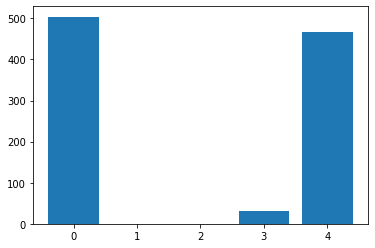

In [196]:
#View the number of points inside each cluster at the final iteration
print(pd.Series(cluster_allocs_recorded).value_counts())

x, y = np.unique(cluster_allocs_recorded, return_counts=True)


plt.bar(x, y)



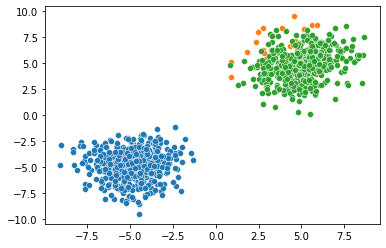

In [197]:
#scatterplot of clusters from last recorded iteration
for h in range(k):
    currd = data[cluster_allocs_recorded == h]
    sns.scatterplot(x=[elem[0] for elem in currd], y=[elem[1] for elem in currd])

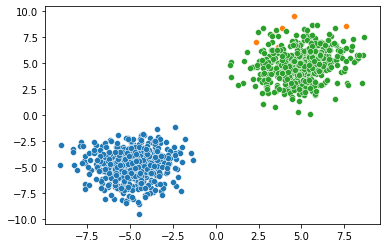

In [203]:
#scatterplot of clusters from last iteration
for h in range(k):
    currd = data[allocs_out[-1] == h]
    sns.scatterplot(x=[elem[0] for elem in currd], y=[elem[1] for elem in currd])

In [24]:
for it in range(len(uniq_vals_out)):
    x, y = np.unique(allocs_out[it], return_counts=True)
    plt.bar(x, y)
    plt.show()
    time.sleep(0.1)
    plt.clf()



NameError: name 'uniq_vals_out' is not defined

In [204]:
uniq_vals_out[-1]

array([[[-4.88790476e+00,  1.40772599e+00,  2.49543196e-01],
        [-4.87126063e+00,  2.49543196e-01,  2.00560808e+00]],

       [[-2.65885634e-03,  2.58835994e+00, -7.79302002e-01],
        [ 7.55276079e-02, -7.79302002e-01,  4.43536424e-01]],

       [[-3.38830096e-01,  4.88673097e-01, -6.70115771e-01],
        [-1.17285868e-01, -6.70115771e-01,  1.41975872e+00]],

       [[ 4.51684073e+00,  4.11878919e+00,  2.23202626e+00],
        [ 6.89150691e+00,  2.23202626e+00,  3.13062623e+00]],

       [[ 4.97406618e+00,  1.67875585e+00,  5.51112464e-01],
        [ 4.76308333e+00,  5.51112464e-01,  2.13658604e+00]],

       [[ 2.23923999e-01,  9.67016208e-02,  4.41878035e-01],
        [ 2.44922374e+00,  4.41878035e-01,  2.64645342e+00]],

       [[ 7.51288154e-01,  3.56847681e+00,  9.39804521e-01],
        [-4.46038942e-01,  9.39804521e-01,  2.63124149e-01]],

       [[-2.21569641e+00,  6.39035515e-01,  5.88764479e-01],
        [-4.16212939e+00,  5.88764479e-01,  1.14494911e+01]]])

In [150]:
len(uniq_vals_out)

299